In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# Load dataset
data = np.load("pneumoniamnist.npz")
X_train, y_train = data["train_images"], data["train_labels"]
X_val, y_val = data["val_images"], data["val_labels"]
X_test, y_test = data["test_images"], data["test_labels"]

In [4]:
print(X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape)

(3882, 28, 28) (3882, 1) (524, 28, 28) (524, 1) (624, 28, 28) (624, 1)


In [5]:
X_train[0].shape


(28, 28)

In [6]:
y_train.shape

(3882, 1)

In [7]:
# Preprocessing
def preprocess(images):
    images = images / 255.0
    images = np.stack([images]*3, axis=-1)  # shape: (N, 28, 28, 3)
    return tf.image.resize(images, [299, 299])

In [8]:
X_train = preprocess(X_train)
X_val = preprocess(X_val)
X_test = preprocess(X_test)

In [9]:
print(X_train.shape, X_val.shape, X_test.shape)

(3882, 299, 299, 3) (524, 299, 299, 3) (624, 299, 299, 3)


In [10]:
#Flattening a multidimensional array into 1D (specifically: flattening labels).
y_train = y_train.ravel()
y_val = y_val.ravel()
y_test = y_test.ravel()

In [11]:
np.unique(y_train,return_counts=1) # imbalance data

(array([0, 1], dtype=uint8), array([ 388, 3494]))

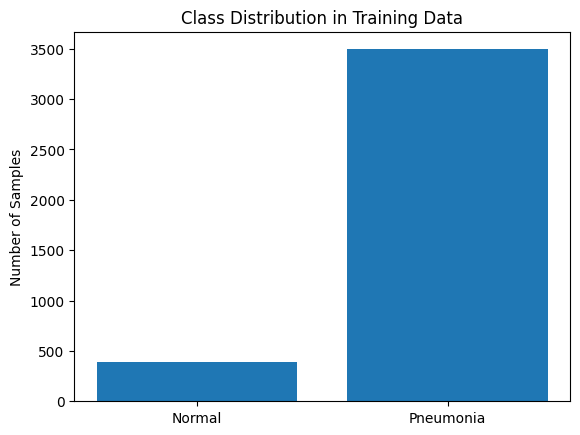

In [21]:
# class distribution plot
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts, tick_label=['Normal', 'Pneumonia'])
plt.title("Class Distribution in Training Data")
plt.ylabel("Number of Samples")
plt.show()


In [12]:
# Class weights
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: weights[i] for i in range(2)}

In [13]:
# Build model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)  # single neuron + sigmoid

model = Model(inputs=base_model.input, outputs=output)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [14]:

# Compile
model.compile(optimizer=Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [15]:
# Train
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history=model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=15,
          batch_size=32,
          class_weight=class_weights,
          callbacks=[early_stop])

Epoch 1/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 68s 380ms/step - accuracy: 0.7725 - loss: 0.5386 - precision: 0.9558 - recall: 0.7834 - val_accuracy: 0.8798 - val_loss: 0.2928 - val_precision: 0.9684 - val_recall: 0.8663
Epoch 2/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - accuracy: 0.8715 - loss: 0.2957 - precision: 0.9826 - recall: 0.8728 - val_accuracy: 0.8760 - val_loss: 0.2905 - val_precision: 0.9793 - val_recall: 0.8509
Epoch 3/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.8769 - loss: 0.2756 - precision: 0.9857 - recall: 0.8778 - val_accuracy: 0.8874 - val_loss: 0.2706 - val_precision: 0.9825 - val_recall: 0.8638
Epoch 4/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.8860 - loss: 0.2434 - precision: 0.9897 - recall: 0.8806 - val_accuracy: 0.8893 - val_loss: 0.2655 - val_precision: 0.9882 - val_recall: 0.8612
Epoch 5/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - accuracy: 0.8972 - loss: 0.2280 - precision: 0.9903 - recall: 0.8936 - val_accuracy: 0.8912

In [16]:
# Evaluate
y_pred_probs = model.predict(X_test).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 652ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.78      0.84       234
           1       0.88      0.95      0.92       390

    accuracy                           0.89       624
   macro avg       0.89      0.87      0.88       624
weighted avg       0.89      0.89      0.89       624

Confusion Matrix:
 [[183  51]
 [ 18 372]]


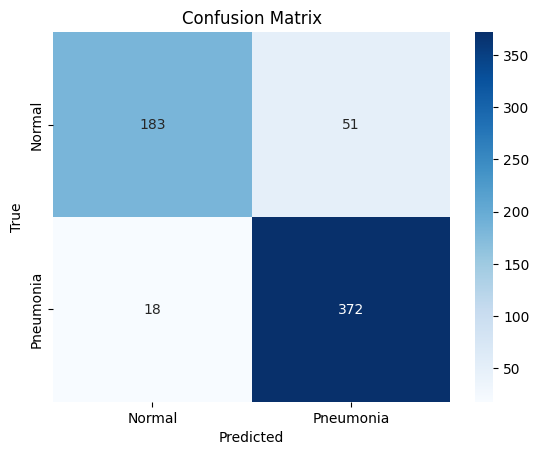

In [19]:
# confusion matrix heatmap
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Normal','Pneumonia'], yticklabels=['Normal','Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


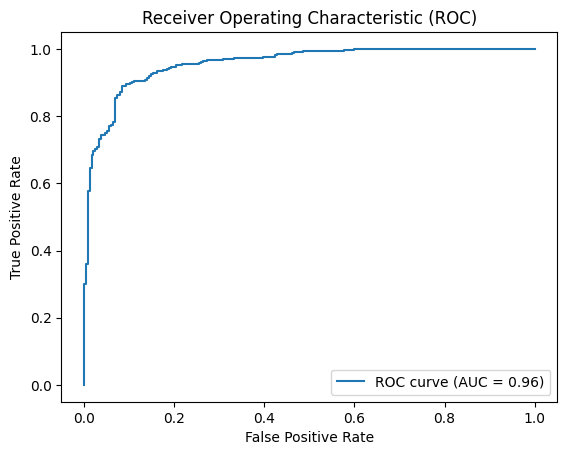

In [20]:
# precision, recall and F1 score curve
from sklearn.metrics import precision_recall_curve, roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc(fpr, tpr))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.show()


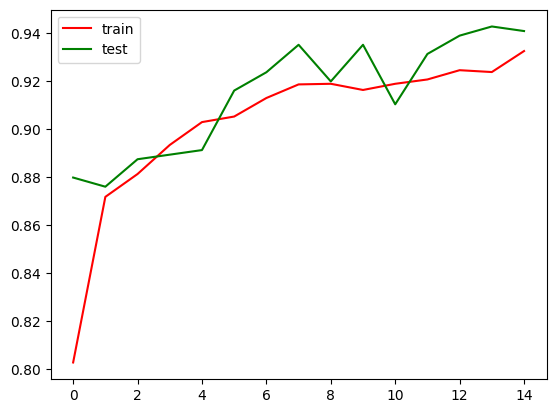

In [17]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='green',label='test')
plt.legend()
plt.show()

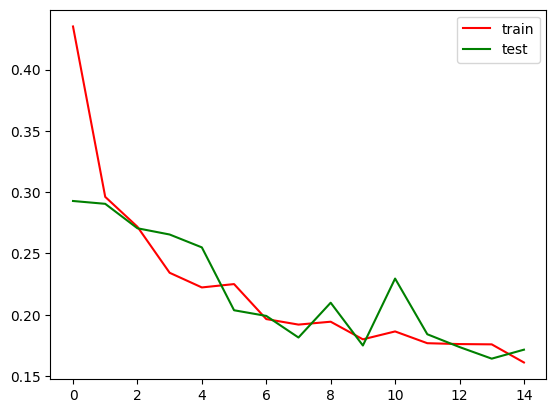

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='green',label='test')
plt.legend()
plt.show()

In [ ]:
# Prediction
